# 🎯 Attention Mechanism Tutorial

이 노트북에서는 Attention 메커니즘을 처음부터 구현하고 실험합니다.
"Attention is All You Need" 논문의 핵심 개념을 직접 코딩해봅니다.

## 1. 환경 설정

In [1]:
import numpy as np
import sys
import os

# 상위 디렉토리를 path에 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('.')))))

# core 모듈 import
from core.attention import (
    scaled_dot_product_attention,
    MultiHeadAttention,
    positional_encoding,
    add_positional_encoding,
    create_causal_mask,
    visualize_attention
)

print("✅ 환경 설정 완료!")
print(f"NumPy 버전: {np.__version__}")

✅ 환경 설정 완료!
NumPy 버전: 2.3.1


## 2. Attention의 직관적 이해

In [2]:
# Attention의 핵심: Query, Key, Value
print("🔍 Attention의 핵심 개념")
print("=" * 50)
print()
print("📝 비유: 도서관에서 책 찾기")
print("  Query (질문): '파이썬 프로그래밍 책을 찾고 있어요'")
print("  Key (색인): 각 책의 제목과 주제")
print("  Value (내용): 실제 책의 내용")
print()
print("→ Attention은 Query와 가장 관련있는 Key를 찾아")
print("  해당하는 Value를 가져오는 메커니즘입니다.")
print()
print("수식: Attention(Q,K,V) = softmax(QK^T/√d_k)V")

🔍 Attention의 핵심 개념

📝 비유: 도서관에서 책 찾기
  Query (질문): '파이썬 프로그래밍 책을 찾고 있어요'
  Key (색인): 각 책의 제목과 주제
  Value (내용): 실제 책의 내용

→ Attention은 Query와 가장 관련있는 Key를 찾아
  해당하는 Value를 가져오는 메커니즘입니다.

수식: Attention(Q,K,V) = softmax(QK^T/√d_k)V


## 3. Scaled Dot-Product Attention 구현

In [5]:
# 간단한 예제로 시작
print("📊 Simple Attention Example")
print("=" * 50)

# 3개의 단어, 각 4차원 벡터
seq_len = 3
d_model = 4

# Query, Key, Value 생성
np.random.seed(42)
Q = np.random.randn(seq_len, d_model)
K = np.random.randn(seq_len, d_model)
V = np.random.randn(seq_len, d_model)

print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"V shape: {V.shape}")

# Attention 계산
output, attention_weights = scaled_dot_product_attention(Q, K, V)

print(f"\n출력 shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"\nAttention weights:\n{attention_weights}")
print(f"\n각 행의 합 (should be 1): {attention_weights.sum(axis=1)}")

📊 Simple Attention Example
Q shape: (3, 4)
K shape: (3, 4)
V shape: (3, 4)

출력 shape: (3, 4)
Attention weights shape: (3, 3)

Attention weights:
[[0.39285909 0.16818537 0.43895554]
 [0.23089671 0.28342933 0.48567396]
 [0.22547439 0.55874566 0.21577995]]

각 행의 합 (should be 1): [1. 1. 1.]


In [6]:
# Attention 계산 단계별 분해
print("🔧 Attention 계산 단계별 분해")
print("=" * 50)

# Step 1: Q와 K의 내적
scores = Q @ K.T
print("Step 1 - Scores (QK^T):")
print(scores)
print(f"Shape: {scores.shape}\n")

# Step 2: Scaling
d_k = K.shape[-1]
scaled_scores = scores / np.sqrt(d_k)
print(f"Step 2 - Scaled scores (÷√{d_k}):")
print(scaled_scores)
print()

# Step 3: Softmax
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

attention_weights_manual = softmax(scaled_scores)
print("Step 3 - Attention weights (softmax):")
print(attention_weights_manual)
print()

# Step 4: 가중합
output_manual = attention_weights_manual @ V
print("Step 4 - Output (weighted sum of V):")
print(output_manual)

# 검증
print(f"\n✅ 수동 계산과 함수 결과 동일: {np.allclose(output, output_manual)}")

🔧 Attention 계산 단계별 분해
Step 1 - Scores (QK^T):
[[-1.58886576 -3.28563423 -1.36697149]
 [-2.76421799 -2.35423325 -1.27708386]
 [-0.09043303  1.72454259 -0.1783279 ]]
Shape: (3, 3)

Step 2 - Scaled scores (÷√4):
[[-0.79443288 -1.64281711 -0.68348575]
 [-1.382109   -1.17711663 -0.63854193]
 [-0.04521651  0.8622713  -0.08916395]]

Step 3 - Attention weights (softmax):
[[0.39285909 0.16818537 0.43895554]
 [0.23089671 0.28342933 0.48567396]
 [0.22547439 0.55874566 0.21577995]]

Step 4 - Output (weighted sum of V):
[[-0.32080902 -0.46976975 -0.19231589 -0.07677361]
 [-0.30249005 -0.57076556 -0.03681329  0.01880544]
 [-0.46126105 -0.36620523 -0.41823183  0.8562291 ]]

✅ 수동 계산과 함수 결과 동일: True


## 4. Self-Attention 실습

In [12]:
# 문장에서 Self-Attention
print("📝 문장에서 Self-Attention")
print("=" * 50)

# 간단한 문장
sentence = "The cat sat"
tokens = sentence.split()
print(f"문장: '{sentence}'")
print(f"토큰: {tokens}\n")

# 각 단어를 임의의 벡터로 표현
np.random.seed(42)
word_embeddings = {
    "The": np.random.randn(8),
    "cat": np.random.randn(8),
    "sat": np.random.randn(8)
}


# 임베딩 행렬 생성
X = np.array([word_embeddings[token] for token in tokens])
print(f"임베딩 shape: {X.shape}")
print(f"임베딩: {X}")

# Self-attention (Q=K=V=X)
output, attention_weights = scaled_dot_product_attention(X, X, X)

# Attention 시각화
print("\nAttention Matrix:")
print("       ", end="")
for token in tokens:
    print(f"{token:>8}", end="")
print()

for i, token in enumerate(tokens):
    print(f"{token:>7}", end="")
    for j in range(len(tokens)):
        weight = attention_weights[i, j]
        print(f"{weight:8.3f}", end="")
    print()

# 해석
print("\n💡 해석:")
for i, token in enumerate(tokens):
    max_idx = np.argmax(attention_weights[i])
    print(f"  '{token}'이 가장 주목하는 단어: '{tokens[max_idx]}' "
          f"(weight: {attention_weights[i, max_idx]:.3f})")

📝 문장에서 Self-Attention
문장: 'The cat sat'
토큰: ['The', 'cat', 'sat']

임베딩 shape: (3, 8)
임베딩: [[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
   1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975  0.24196227 -1.91328024
  -1.72491783 -0.56228753]
 [-1.01283112  0.31424733 -0.90802408 -1.4123037   1.46564877 -0.2257763
   0.0675282  -1.42474819]]

Attention Matrix:
            The     cat     sat
    The   0.954   0.025   0.021
    cat   0.012   0.833   0.155
    sat   0.009   0.145   0.845

💡 해석:
  'The'이 가장 주목하는 단어: 'The' (weight: 0.954)
  'cat'이 가장 주목하는 단어: 'cat' (weight: 0.833)
  'sat'이 가장 주목하는 단어: 'sat' (weight: 0.845)


## 5. Causal Attention (GPT 스타일)

In [13]:
# Causal mask 생성 및 적용
print("🔮 Causal Attention (미래를 볼 수 없음)")
print("=" * 50)

# 더 긴 문장
sentence = "I think therefore I am"
tokens = sentence.split()
seq_len = len(tokens)
print(f"문장: '{sentence}'")
print(f"토큰: {tokens}\n")

# 임베딩
np.random.seed(42)
X = np.random.randn(seq_len, 16)

# Causal mask 생성
causal_mask = create_causal_mask(seq_len)
print("Causal Mask:")
print(causal_mask)
print()

# Causal attention 적용
output, attention_weights = scaled_dot_product_attention(X, X, X, mask=causal_mask)

# 시각화
print("Causal Attention Weights:")
print("       ", end="")
for token in tokens:
    print(f"{token:>10}", end="")
print()

for i, token in enumerate(tokens):
    print(f"{token:>7}", end="")
    for j in range(seq_len):
        weight = attention_weights[i, j]
        if weight < 0.001:
            print("         -", end="")
        else:
            print(f"{weight:10.3f}", end="")
    print()

print("\n💡 특징:")
print("  - 하삼각 행렬 형태")
print("  - 각 토큰은 자신과 이전 토큰만 볼 수 있음")
print("  - GPT와 같은 생성 모델에서 사용")

🔮 Causal Attention (미래를 볼 수 없음)
문장: 'I think therefore I am'
토큰: ['I', 'think', 'therefore', 'I', 'am']

Causal Mask:
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]

Causal Attention Weights:
                I     think therefore         I        am
      I     1.000         -         -         -         -
  think     0.012     0.988         -         -         -
therefore     0.020     0.080     0.900         -         -
      I     0.165     0.019     0.040     0.776         -
     am     0.030     0.002     0.002     0.006     0.959

💡 특징:
  - 하삼각 행렬 형태
  - 각 토큰은 자신과 이전 토큰만 볼 수 있음
  - GPT와 같은 생성 모델에서 사용


## 6. Multi-Head Attention

In [15]:
# Multi-Head Attention 실습
print("🎭 Multi-Head Attention")
print("=" * 50)

# 설정
d_model = 64
num_heads = 8
seq_len = 10

print(f"Model dimension: {d_model}")
print(f"Number of heads: {num_heads}")
print(f"Dimension per head: {d_model // num_heads}\n")

# Multi-Head Attention 생성
mha = MultiHeadAttention(d_model, num_heads)

# 입력 데이터
X = np.random.randn(seq_len, d_model)
print(f"입력 shape: {X.shape}")

# Forward pass
output, attention_weights = mha.forward(X, X, X)

print(f"출력 shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"  (num_heads, seq_len, seq_len)\n")

# 각 head의 attention 패턴 분석
print("각 Head의 특성:")
for head_idx in range(num_heads):
    head_weights = attention_weights[head_idx]
    
    # 대각선 강도 (자기 자신에 대한 attention)
    diagonal_strength = np.mean(np.diag(head_weights))
    
    # 분산 (attention의 집중도)
    variance = np.var(head_weights)
    
    print(f"  Head {head_idx + 1}: "
          f"대각선 강도={diagonal_strength:.3f}, "
          f"분산={variance:.3f}")

🎭 Multi-Head Attention
Model dimension: 64
Number of heads: 8
Dimension per head: 8

입력 shape: (10, 64)
출력 shape: (10, 64)
Attention weights shape: (8, 10, 10)
  (num_heads, seq_len, seq_len)

각 Head의 특성:
  Head 1: 대각선 강도=0.101, 분산=0.031
  Head 2: 대각선 강도=0.041, 분산=0.016
  Head 3: 대각선 강도=0.093, 분산=0.024
  Head 4: 대각선 강도=0.130, 분산=0.032
  Head 5: 대각선 강도=0.138, 분산=0.022
  Head 6: 대각선 강도=0.046, 분산=0.020
  Head 7: 대각선 강도=0.050, 분산=0.022
  Head 8: 대각선 강도=0.032, 분산=0.024


In [14]:
# 간단한 예시
x = np.array([
    # 배치 0
    [
        [1, 2, 3, 4],      # 단어 0의 특징
        [5, 6, 7, 8],      # 단어 1의 특징
        [9, 10, 11, 12],   # 단어 2의 특징
    ],
    # 배치 1  
    [
        [13, 14, 15, 16],  # 단어 0의 특징
        [17, 18, 19, 20],  # 단어 1의 특징
        [21, 22, 23, 24],  # 단어 2의 특징
    ]
])
# x.shape = (2, 3, 4)

# 2개 head로 분할 (d_k = 2)
x_reshaped = x.reshape(2, 3, 2, 2)
# x_reshaped.shape = (2, 3, 2, 2)

print("원본:")
print(x)
print("\nReshape 후:")
print(x_reshaped)

원본:
[[[ 1  2  3  4]
  [ 5  6  7  8]
  [ 9 10 11 12]]

 [[13 14 15 16]
  [17 18 19 20]
  [21 22 23 24]]]

Reshape 후:
[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]

  [[ 9 10]
   [11 12]]]


 [[[13 14]
   [15 16]]

  [[17 18]
   [19 20]]

  [[21 22]
   [23 24]]]]


In [16]:
# Multi-Head의 장점 시연
print("💡 Multi-Head의 장점")
print("=" * 50)
print()
print("Single Head vs Multi-Head 비교:")
print()

# Single Head (큰 차원)
single_head = MultiHeadAttention(d_model=64, num_heads=1)

# Multi-Head (여러 작은 차원)
multi_head = MultiHeadAttention(d_model=64, num_heads=8)

# 동일한 입력
X = np.random.randn(10, 64)

# Forward pass
output_single, weights_single = single_head.forward(X, X, X)
output_multi, weights_multi = multi_head.forward(X, X, X)

print("1. Single Head:")
print(f"   - 1개의 64차원 attention")
print(f"   - 하나의 관점만 학습")
print(f"   - Attention 분산: {np.var(weights_single):.4f}")
print()

print("2. Multi-Head (8 heads):")
print(f"   - 8개의 8차원 attention")
print(f"   - 다양한 관점 동시 학습")

# 각 head의 다양성
head_variances = [np.var(weights_multi[i]) for i in range(8)]
print(f"   - Head별 분산: {[f'{v:.4f}' for v in head_variances[:4]]} ...")
print(f"   - 평균 분산: {np.mean(head_variances):.4f}")
print()
print("→ Multi-Head는 다양한 패턴을 동시에 학습할 수 있습니다!")

💡 Multi-Head의 장점

Single Head vs Multi-Head 비교:

1. Single Head:
   - 1개의 64차원 attention
   - 하나의 관점만 학습
   - Attention 분산: 0.0264

2. Multi-Head (8 heads):
   - 8개의 8차원 attention
   - 다양한 관점 동시 학습
   - Head별 분산: ['0.0425', '0.0211', '0.0274', '0.0339'] ...
   - 평균 분산: 0.0329

→ Multi-Head는 다양한 패턴을 동시에 학습할 수 있습니다!


## 7. Positional Encoding

In [ ]:
# Positional Encoding 생성 및 분석
print("📍 Positional Encoding")
print("=" * 50)

# PE 생성
seq_len = 50
d_model = 128

pe = positional_encoding(seq_len, d_model)
print(f"PE shape: {pe.shape}")
print(f"PE 값 범위: [{pe.min():.3f}, {pe.max():.3f}]\n")

# 처음 몇 개 위치의 패턴
print("처음 5개 위치의 처음 8차원:")
print("Pos  ", end="")
for dim in range(8):
    print(f"Dim{dim:2d}  ", end="")
print()

for pos in range(5):
    print(f"{pos:3d}  ", end="")
    for dim in range(8):
        val = pe[pos, dim]
        print(f"{val:6.3f} ", end="")
    print()

# 주파수 특성
print("\n📊 차원별 주파수 특성:")
for dim in [0, 32, 64, 127]:
    # 주기 계산
    if dim % 2 == 0:
        wavelength = 2 * np.pi * (10000 ** (dim / d_model))
        print(f"  Dim {dim:3d}: 파장 ≈ {wavelength:.1f} positions")

In [17]:
import numpy as np

seq_len = 5
d_model = 6
base = 10000

# 1. 초기화
pe = np.zeros((5, 6))
print("초기화:")
print(pe)
print()

# 2. 위치 인덱스
position = np.arange(5)[:, np.newaxis]
print("위치 인덱스:")
print(position)
print()

# 3. 주파수 항
div_term = np.exp(np.arange(0, 6, 2) * -(np.log(10000) / 6))
print("주파수 항:")
print(div_term)
print()

# 4. Sin, Cos 적용
pe[:, 0::2] = np.sin(position * div_term)  # 0, 2, 4번째 차원
pe[:, 1::2] = np.cos(position * div_term)  # 1, 3, 5번째 차원

print("최종 Positional Encoding:")
print(pe)

초기화:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

위치 인덱스:
[[0]
 [1]
 [2]
 [3]
 [4]]

주파수 항:
[1.         0.04641589 0.00215443]

최종 Positional Encoding:
[[ 0.          1.          0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.04639922  0.99892298  0.00215443  0.99999768]
 [ 0.90929743 -0.41614684  0.0926985   0.99569422  0.00430886  0.99999072]
 [ 0.14112001 -0.9899925   0.1387981   0.9903207   0.00646326  0.99997911]
 [-0.7568025  -0.65364362  0.18459872  0.98281398  0.00861763  0.99996287]]


In [18]:
# PE의 효과 시연
print("🔬 Positional Encoding의 효과")
print("=" * 50)

# 동일한 단어가 다른 위치에 있을 때
sentence = "The cat and the dog"
tokens = sentence.split()
print(f"문장: '{sentence}'")
print(f"토큰: {tokens}")
print(f"  'the'가 위치 0과 3에 나타남\n")

# 간단한 임베딩 (the는 같은 벡터)
embedding_dim = 32
word_embeddings = {
    "The": np.ones(embedding_dim) * 0.1,
    "the": np.ones(embedding_dim) * 0.1,  # 같은 벡터
    "cat": np.ones(embedding_dim) * 0.2,
    "and": np.ones(embedding_dim) * 0.3,
    "dog": np.ones(embedding_dim) * 0.4
}

# 임베딩 행렬
X = np.array([word_embeddings[token] for token in tokens])

# PE 없이
print("1. PE 없이:")
print(f"   'The' 벡터 평균: {X[0].mean():.3f}")
print(f"   'the' 벡터 평균: {X[3].mean():.3f}")
print(f"   → 동일한 벡터!\n")

# PE 추가
X_with_pe = add_positional_encoding(X)
print("2. PE 추가 후:")
print(f"   'The' (pos 0) 벡터 평균: {X_with_pe[0].mean():.3f}")
print(f"   'the' (pos 3) 벡터 평균: {X_with_pe[3].mean():.3f}")
print(f"   → 다른 벡터!")
print()
print("→ PE를 통해 위치 정보가 추가되어 같은 단어도 구별 가능")

🔬 Positional Encoding의 효과
문장: 'The cat and the dog'
토큰: ['The', 'cat', 'and', 'the', 'dog']
  'the'가 위치 0과 3에 나타남

1. PE 없이:
   'The' 벡터 평균: 0.100
   'the' 벡터 평균: 0.100
   → 동일한 벡터!

2. PE 추가 후:
   'The' (pos 0) 벡터 평균: 0.600
   'the' (pos 3) 벡터 평균: 0.581
   → 다른 벡터!

→ PE를 통해 위치 정보가 추가되어 같은 단어도 구별 가능


## 8. 실전 예제: 간단한 Transformer Block

In [19]:
# 간단한 Transformer Block 구현
class SimpleTransformerBlock:
    """간단한 Transformer 블록"""
    
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        self.attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.d_model = d_model
        
        # Feed-forward network weights
        self.ff_w1 = np.random.randn(d_model, d_model * 4) * 0.1
        self.ff_w2 = np.random.randn(d_model * 4, d_model) * 0.1
    
    def forward(self, x, mask=None):
        # 1. Multi-Head Attention
        attn_output, attn_weights = self.attention.forward(x, x, x, mask)
        
        # 2. Residual connection + Layer Norm (simplified)
        x = x + attn_output
        x = self.layer_norm(x)
        
        # 3. Feed-forward
        ff_output = self.feed_forward(x)
        
        # 4. Residual connection + Layer Norm
        x = x + ff_output
        x = self.layer_norm(x)
        
        return x, attn_weights
    
    def feed_forward(self, x):
        """Position-wise feed-forward network"""
        # Linear -> ReLU -> Linear
        hidden = np.maximum(0, x @ self.ff_w1)  # ReLU
        output = hidden @ self.ff_w2
        return output
    
    def layer_norm(self, x, eps=1e-6):
        """Layer normalization"""
        mean = x.mean(axis=-1, keepdims=True)
        std = x.std(axis=-1, keepdims=True)
        return (x - mean) / (std + eps)

# Transformer Block 테스트
print("🏗️ Simple Transformer Block")
print("=" * 50)

# 생성
transformer = SimpleTransformerBlock(d_model=64, num_heads=8)

# 입력 (with PE)
seq_len = 10
X = np.random.randn(seq_len, 64)
X = add_positional_encoding(X)

# Forward pass
output, attention = transformer.forward(X)

print(f"입력 shape: {X.shape}")
print(f"출력 shape: {output.shape}")
print(f"Attention shape: {attention.shape}")
print()
print("구성 요소:")
print("  1. Multi-Head Attention")
print("  2. Residual Connection")
print("  3. Layer Normalization")
print("  4. Feed-Forward Network")
print("  5. Another Residual + LayerNorm")
print()
print("→ 이것이 Transformer의 기본 블록입니다!")

🏗️ Simple Transformer Block
입력 shape: (10, 64)
출력 shape: (10, 64)
Attention shape: (8, 10, 10)

구성 요소:
  1. Multi-Head Attention
  2. Residual Connection
  3. Layer Normalization
  4. Feed-Forward Network
  5. Another Residual + LayerNorm

→ 이것이 Transformer의 기본 블록입니다!


In [22]:
import numpy as np

# 설정
batch_size = 2
seq_len = 3
d_model = 4

# 입력 데이터
x = np.random.randn(batch_size, seq_len, d_model)
print(f"입력 shape: {x.shape}")
print(f"입력 값:\n{x}")

# 1단계: Self-Attention (가정)
attn_output = np.random.randn(batch_size, seq_len, d_model) * 0.1
print(f"\nAttention 출력:\n{attn_output}")

# 2단계: Residual + Layer Norm
x = x + attn_output
print(f"\nResidual 후:\n{x}")

# Layer Norm (간단한 버전)
mean = np.mean(x, axis=-1, keepdims=True)
var = np.var(x, axis=-1, keepdims=True)
x = (x - mean) / np.sqrt(var + 1e-6)
print(f"\nLayer Norm 후:\n{x}")

# 3단계: Feed-Forward (가정)
ff_output = np.random.randn(batch_size, seq_len, d_model) * 0.1
print(f"\nFeed-Forward 출력:\n{ff_output}")

# 4단계: 두 번째 Residual + Layer Norm
x = x + ff_output
print(f"\n두 번째 Residual 후:\n{x}")

# 최종 Layer Norm
mean = np.mean(x, axis=-1, keepdims=True)
var = np.var(x, axis=-1, keepdims=True)
x = (x - mean) / np.sqrt(var + 1e-6)
print(f"\n최종 Layer Norm 후:\n{x}")

입력 shape: (2, 3, 4)
입력 값:
[[[-2.04905521  1.47926649  0.89024727  0.37480383]
  [-0.15420973 -1.5365512  -0.10442649  0.39583643]
  [-1.32714425  0.77379263 -1.77039224  1.80327198]]

 [[ 0.05684915 -0.11519803  0.4638339  -1.2636555 ]
  [ 1.37259032  0.74536726  1.30657607 -0.06256445]
  [-1.6181128  -1.38441537  1.03840968 -0.158426  ]]]

Attention 출력:
[[[ 0.07653179  0.14218127  0.10137514  0.07876944]
  [-0.05597804  0.21980439 -0.09463949  0.08145679]
  [ 0.03367227  0.05592733 -0.13191882  0.18883682]]

 [[-0.23215914 -0.25038028 -0.18049511  0.10472162]
  [-0.18826984 -0.08945959 -0.00230802  0.04703809]
  [-0.04494361  0.15722834 -0.04599182  0.08773165]]]

Residual 후:
[[[-1.97252342  1.62144776  0.99162241  0.45357327]
  [-0.21018777 -1.31674681 -0.19906599  0.47729323]
  [-1.29347198  0.82971997 -1.90231106  1.9921088 ]]

 [[-0.17530999 -0.36557831  0.28333879 -1.15893388]
  [ 1.18432048  0.65590767  1.30426805 -0.01552637]
  [-1.66305641 -1.22718703  0.99241786 -0.07069435]]

## 9. Attention 패턴 실험

In [20]:
# 다양한 Attention 패턴 생성 및 비교
print("🎨 다양한 Attention 패턴")
print("=" * 50)

seq_len = 8

# 1. Identity Attention (자기 자신만)
identity_attention = np.eye(seq_len)

# 2. Uniform Attention (균등)
uniform_attention = np.ones((seq_len, seq_len)) / seq_len

# 3. Local Attention (인접 토큰)
local_attention = np.zeros((seq_len, seq_len))
for i in range(seq_len):
    for j in range(max(0, i-1), min(seq_len, i+2)):
        local_attention[i, j] = 1/3

# 4. Global + Local (혼합)
mixed_attention = 0.7 * local_attention + 0.3 * uniform_attention

# 시각화
patterns = [
    ("Identity (자기 자신만)", identity_attention),
    ("Uniform (균등 분포)", uniform_attention),
    ("Local (인접 토큰)", local_attention),
    ("Mixed (Global + Local)", mixed_attention)
]

for name, pattern in patterns:
    print(f"\n{name}:")
    for i in range(min(5, seq_len)):
        print(" ", end="")
        for j in range(min(8, seq_len)):
            val = pattern[i, j]
            if val > 0.5:
                print("██", end="")
            elif val > 0.2:
                print("▓▓", end="")
            elif val > 0.05:
                print("░░", end="")
            else:
                print("··", end="")
        print()

🎨 다양한 Attention 패턴

Identity (자기 자신만):
 ██··············
 ··██············
 ····██··········
 ······██········
 ········██······

Uniform (균등 분포):
 ░░░░░░░░░░░░░░░░
 ░░░░░░░░░░░░░░░░
 ░░░░░░░░░░░░░░░░
 ░░░░░░░░░░░░░░░░
 ░░░░░░░░░░░░░░░░

Local (인접 토큰):
 ▓▓▓▓············
 ▓▓▓▓▓▓··········
 ··▓▓▓▓▓▓········
 ····▓▓▓▓▓▓······
 ······▓▓▓▓▓▓····

Mixed (Global + Local):
 ▓▓▓▓············
 ▓▓▓▓▓▓··········
 ··▓▓▓▓▓▓········
 ····▓▓▓▓▓▓······
 ······▓▓▓▓▓▓····


## 10. 성능 분석

In [21]:
import time

# Attention 계산 복잡도 분석
print("⚡ Attention 계산 복잡도")
print("=" * 50)

# 다양한 시퀀스 길이에서 테스트
seq_lengths = [10, 50, 100, 200]
d_model = 64

print(f"d_model = {d_model}\n")
print("Seq Length | Time (ms) | Memory (MB) | Complexity")
print("-" * 55)

for seq_len in seq_lengths:
    # 입력 생성
    Q = K = V = np.random.randn(seq_len, d_model)
    
    # 시간 측정
    start = time.time()
    for _ in range(100):
        _, _ = scaled_dot_product_attention(Q, K, V)
    elapsed = (time.time() - start) / 100 * 1000  # ms
    
    # 메모리 추정 (attention matrix)
    memory_mb = (seq_len * seq_len * 8) / (1024 * 1024)  # 8 bytes per float64
    
    print(f"{seq_len:10d} | {elapsed:9.2f} | {memory_mb:11.2f} | O(n²)")

print("\n💡 관찰:")
print("  - 시퀀스 길이의 제곱에 비례하는 계산량")
print("  - 긴 시퀀스에서 메모리 문제 발생 가능")
print("  - 이래서 효율적인 Attention 변형들이 연구됨")

⚡ Attention 계산 복잡도
d_model = 64

Seq Length | Time (ms) | Memory (MB) | Complexity
-------------------------------------------------------
        10 |      0.01 |        0.00 | O(n²)
        50 |      0.05 |        0.02 | O(n²)
       100 |      0.11 |        0.08 | O(n²)
       200 |      0.31 |        0.31 | O(n²)

💡 관찰:
  - 시퀀스 길이의 제곱에 비례하는 계산량
  - 긴 시퀀스에서 메모리 문제 발생 가능
  - 이래서 효율적인 Attention 변형들이 연구됨


/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/seabor

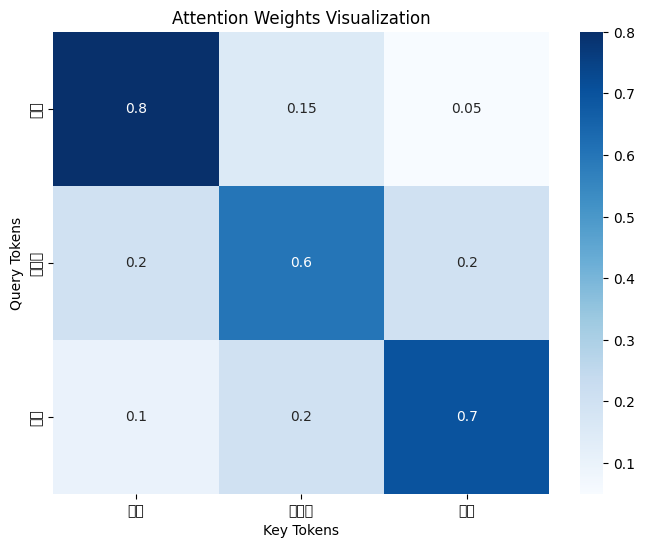

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attention_weights, tokens):
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_weights, 
                xticklabels=tokens, 
                yticklabels=tokens,
                annot=True, 
                cmap='Blues')
    plt.title('Attention Weights Visualization')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.show()

# 예시 데이터
tokens = ["나는", "학교에", "갔다"]
attention_weights = [
    [0.8, 0.15, 0.05],  # "나는"의 attention
    [0.2, 0.6, 0.2],    # "학교에"의 attention
    [0.1, 0.2, 0.7]     # "갔다"의 attention
]

visualize_attention(attention_weights, tokens)

## 🎉 축하합니다!

Attention 메커니즘의 핵심을 모두 구현하고 이해했습니다!

### 배운 내용:
1. ✅ Scaled Dot-Product Attention
2. ✅ Self-Attention과 Cross-Attention
3. ✅ Causal Masking
4. ✅ Multi-Head Attention
5. ✅ Positional Encoding
6. ✅ 간단한 Transformer Block

### 다음 단계:
- Day 4: 완전한 Transformer 구현
- Layer Normalization, Residual Connection
- Encoder-Decoder 구조

"Attention is literally all you need!"